x_train shape: (12000, 28, 28), y_train shape: (12000,)
x_test shape: (2000, 28, 28), y_test shape: (2000,)
Unique classes in training set: [2 3]
Unique classes in test set: [2 3]


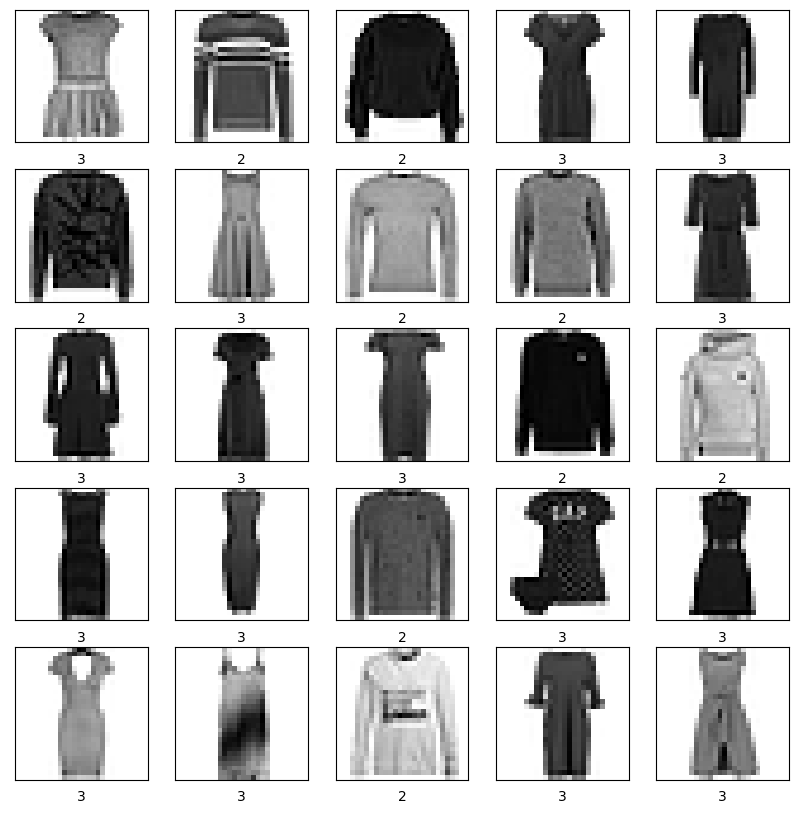

x_train shape after split: (11200, 28, 28), y_train shape after split: (11200,)
x_val shape: (1400, 28, 28), y_val shape: (1400,)
x_test shape: (1400, 28, 28), y_test shape: (1400,)


In [7]:
#LOADING AND SCALING
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 3))
test_filter = np.where((y_test == 2) | (y_test == 3))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

unique_classes_train = np.unique(y_train)
unique_classes_test = np.unique(y_test)
print(f"Unique classes in training set: {unique_classes_train}")
print(f"Unique classes in test set: {unique_classes_test}")

x_train = x_train / 255.0
x_test = x_test / 255.0

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

x_all = np.concatenate((x_train, x_test))
y_all = np.concatenate((y_train, y_test))

num_train = int(0.8 * len(x_all))
num_val = int(0.1 * len(x_all))
num_test = len(x_all) - num_train - num_val

x_train, y_train = x_all[:num_train], y_all[:num_train]
x_val, y_val = x_all[num_train:num_train + num_val], y_all[num_train:num_train + num_val]
x_test, y_test = x_all[num_train + num_val:], y_all[num_train + num_val:]

print(f"x_train shape after split: {x_train.shape}, y_train shape after split: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


BASELINE ARCHITECT

Epoch 1/50
44/44 [==============================] - 13s 258ms/step - loss: 0.4396 - val_loss: 0.3610
Epoch 2/50
44/44 [==============================] - 11s 250ms/step - loss: 0.3400 - val_loss: 0.3258
Epoch 3/50
44/44 [==============================] - 10s 232ms/step - loss: 0.3209 - val_loss: 0.3126
Epoch 4/50
44/44 [==============================] - 10s 228ms/step - loss: 0.3120 - val_loss: 0.3057
Epoch 5/50
44/44 [==============================] - 10s 229ms/step - loss: 0.3063 - val_loss: 0.3018
Epoch 6/50
44/44 [==============================] - 10s 227ms/step - loss: 0.3022 - val_loss: 0.2976
Epoch 7/50
44/44 [==============================] - 10s 222ms/step - loss: 0.2993 - val_loss: 0.2952
Epoch 8/50
44/44 [==============================] - 10s 226ms/step - loss: 0.2966 - val_loss: 0.2927
Epoch 9/50
44/44 [==============================] - 10s 228ms/step - loss: 0.2945 - val_loss: 0.2922
Epoch 10/50
44/44 [==============================] - 10s 227ms/step - loss: 0.2928 - val_lo

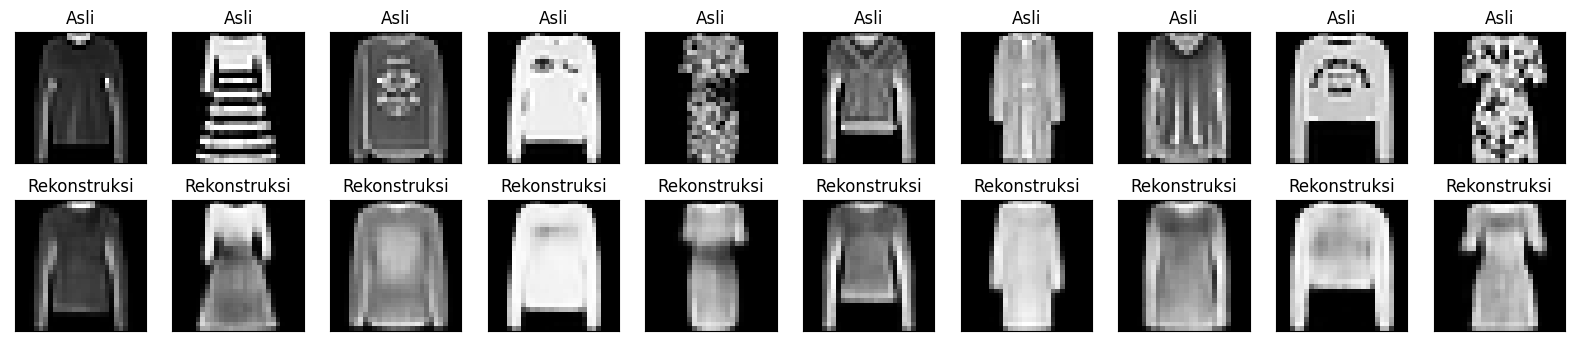

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(128, activation='relu')(x)

x = Dense(6272, activation='relu')(encoded)
x = Reshape((7, 7, 128))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val))

decoded_imgs = autoencoder.predict(x_test)

ssim_values = [ssim(x_test[i].squeeze(), decoded_imgs[i].squeeze(), data_range=decoded_imgs[i].max() - decoded_imgs[i].min()) for i in range(len(x_test))]

mean_ssim = np.mean(ssim_values)
print(f"Rata-rata SSIM pada data test: {mean_ssim}")

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Asli")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.title("Rekonstruksi")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


MODIFICATION ARCHITECT

Epoch 1/100
88/88 [==============================] - 18s 182ms/step - loss: 0.3704 - val_loss: 0.6905 - lr: 0.0010
Epoch 2/100
88/88 [==============================] - 21s 238ms/step - loss: 0.3054 - val_loss: 0.6414 - lr: 0.0010
Epoch 3/100
88/88 [==============================] - 31s 348ms/step - loss: 0.2961 - val_loss: 0.6019 - lr: 0.0010
Epoch 4/100
88/88 [==============================] - 26s 301ms/step - loss: 0.2920 - val_loss: 0.4805 - lr: 0.0010
Epoch 5/100
88/88 [==============================] - 18s 201ms/step - loss: 0.2886 - val_loss: 0.3784 - lr: 0.0010
Epoch 6/100
88/88 [==============================] - 17s 189ms/step - loss: 0.2867 - val_loss: 0.3239 - lr: 0.0010
Epoch 7/100
88/88 [==============================] - 16s 177ms/step - loss: 0.2858 - val_loss: 0.3052 - lr: 0.0010
Epoch 8/100
88/88 [==============================] - 16s 187ms/step - loss: 0.2843 - val_loss: 0.2824 - lr: 0.0010
Epoch 9/100
88/88 [==============================] - 17s 196ms/step - loss: 0.28

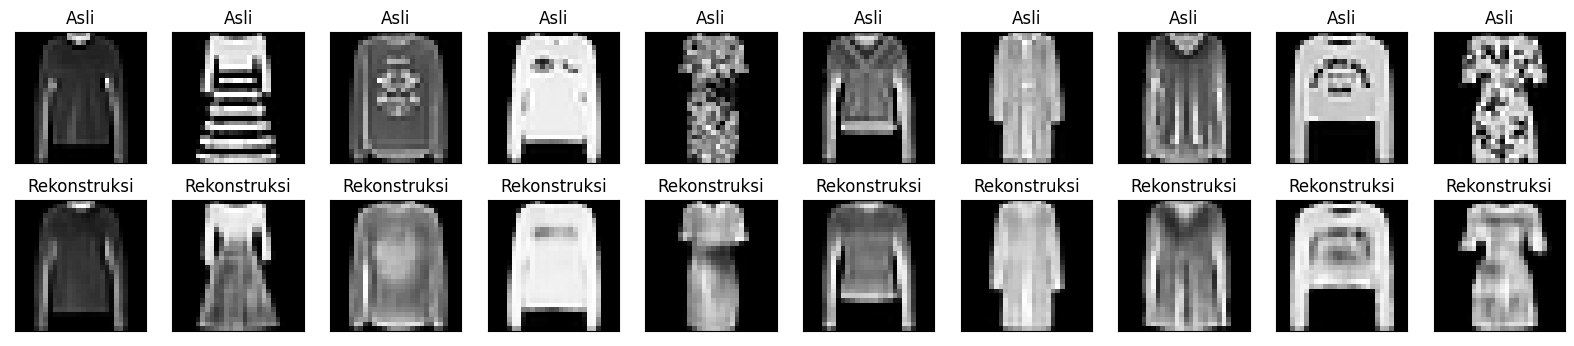

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, Dropout
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(128, activation='relu')(x)

x = Dense(7*7*64, activation='relu')(encoded)
x = Reshape((7, 7, 64))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[early_stopping, reduce_lr])

decoded_imgs = autoencoder.predict(x_test)

ssim_values = [ssim(x_test[i].squeeze(), decoded_imgs[i].squeeze(), data_range=decoded_imgs[i].max() - decoded_imgs[i].min()) for i in range(len(x_test))]

mean_ssim = np.mean(ssim_values)
print(f"Rata-rata SSIM pada data test setelah modifikasi: {mean_ssim}")

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Asli")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.title("Rekonstruksi")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


HASIL EVALUASI 

Hasil dari model Autoencoder yang sudah dimodifikasi menunjukkan peningkatan dalam kualitas rekonstruksi gambar dengan nilai SSIM rata-rata 0.8706 pada data test. SSIM yang lebih tinggi ini menandakan bahwa gambar hasil rekonstruksi lebih mirip dengan gambar asli dibandingkan dengan model dasar sebelumnya. Peningkatan ini disebabkan oleh penambahan layer convolutional dan penggunaan batch normalization yang membantu dalam menangkap fitur-fitur penting dari gambar, selain itu penggunaan EarlyStopping dan reduce learning rate juga membantu dalam mencegah overfitting